In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
ratings = pd.read_csv('data/ratings.dat', sep = '::', header = None)
movies = pd.read_csv('data/movies.dat', sep = '::', header = None)
users = pd.read_csv('data/users.dat', sep = '::', header = None)
ratings.columns = ['userId', 'movieId', 'rating', 'timestamp']
movies.columns = ['movieId', 'name', 'genres']
users.columns = ['userId', 'sex', 'age', 'occupation', 'zipcode']
movie_ratings = pd.merge(ratings, movies, on = 'movieId')
movie_ratings = pd.merge(movie_ratings, users, on = 'userId')

In [3]:
movie_ratings.head()

,userId,movieId,rating,timestamp,name,genres,sex,age,occupation,zipcode
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067


In [4]:
movie_ratings.shape

(1000209, 10)

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from deepctr.models import WDL
from deepctr.inputs import SparseFeat, DenseFeat, VarLenSparseFeat, get_feature_names

In [20]:
def split(x):
    key_ans = x.split('|')
    for key in key_ans:
        if key not in key2index:
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))

In [21]:
sparse_features = ['movieId', 'userId','occupation', 'zipcode']
dense_features = ['timestamp', 'age']

movie_ratings[sparse_features] = movie_ratings[sparse_features].fillna('-1',)
movie_ratings[dense_features] = movie_ratings[dense_features].fillna(0,)

target = ['rating']

In [22]:
# sampling train and test
train, test = train_test_split(movie_ratings, test_size = 0.2)

In [23]:
# concat train and test for preprocessing
data = pd.concat([train, test])

In [24]:
data.head()

,userId,movieId,rating,timestamp,name,genres,sex,age,occupation,zipcode
461798,629,3879,3,975783216,"Art of War, The (2000)",Action,F,1,10,48154
912724,229,367,2,976823202,"Mask, The (1994)",Comedy|Crime|Fantasy,M,18,10,04576
344927,4510,3591,2,964989467,Mr. Mom (1983),Comedy|Drama,M,45,7,92503
406474,5433,2282,4,960049423,Pecker (1998),Comedy|Drama,F,35,17,45014
700641,93,3877,1,977630767,Supergirl (1984),Action|Adventure|Fantasy,M,25,17,95825


In [28]:
from sklearn.preprocessing import MinMaxScaler

# lable encoder sparse data
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])

scaler = MinMaxScaler()
data[dense_features] = scaler.fit_transform(data[dense_features])

In [29]:
data.head()

,userId,movieId,rating,timestamp,name,genres,sex,age,occupation,zipcode
461798,628,3633,3,0.212581,"Art of War, The (2000)",Action,F,0.000000,10,1615
912724,228,357,2,0.224168,"Mask, The (1994)",Comedy|Crime|Fantasy,M,0.309091,10,242
344927,4509,3351,2,0.092317,Mr. Mom (1983),Comedy|Drama,M,0.800000,7,2946
406474,5432,2090,4,0.037275,Pecker (1998),Comedy|Drama,F,0.618182,17,1475
700641,92,3631,1,0.233166,Supergirl (1984),Action|Adventure|Fantasy,M,0.436364,17,3227


In [30]:
# preprocess the sequence data
key2index = {}
genres_list = list(map(split, data['genres'].values))
# print(genres_list)
genres_length = np.array(list(map(len, genres_list)))
max_len = max(genres_length)
genres_list = pad_sequences(genres_list, maxlen=max_len, padding='post')

In [31]:
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique(), embedding_dim = 4)
                         for feat in sparse_features] + [DenseFeat(feat, 1, ) for feat in dense_features]

varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres', vocabulary_size = len(
    key2index) + 1, embedding_dim = 4), maxlen=max_len, combiner='mean',
                                          weight_name = None)]

linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

# print("Type of linear_feature_columns is {0} and the shape of linear_feature_columns is {1}".format(type(linear_feature_columns), len(linear_feature_columns)))
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
# print(feature_names)

In [32]:
train = data[:train.shape[0]]
test = data[train.shape[0]:]

In [33]:
train_genres_list = list(map(split, train['genres'].values))
train_genres_list = pad_sequences(train_genres_list, maxlen=max_len, padding='post')
test_genres_list = list(map(split, test['genres'].values))
test_genres_list = pad_sequences(test_genres_list, maxlen=max_len, padding='post')

In [34]:
train_model_input = {name: train[name].values for name in feature_names}
train_model_input["genres"] = train_genres_list
test_model_input = {name: test[name].values for name in feature_names}
test_model_input["genres"] = test_genres_list

In [42]:
model = WDL(linear_feature_columns, dnn_feature_columns, task='regression')
model.compile("adam", "mse", metrics=['mse'])
es = EarlyStopping(monitor='val_mse', mode='min')
history = model.fit(train_model_input, train[target].values, callbacks= [es], batch_size=256, epochs=30, verbose=True, validation_split=0.2)

Train on 640133 samples, validate on 160034 samples
Epoch 1/30
640133/640133 [==============================] - 16s 25us/sample - loss: 0.9363 - mse: 0.9356 - val_loss: 0.8267 - val_mse: 0.8254
Epoch 2/30
640133/640133 [==============================] - 14s 22us/sample - loss: 0.8101 - mse: 0.8082 - val_loss: 0.8081 - val_mse: 0.8056
Epoch 3/30
640133/640133 [==============================] - 14s 22us/sample - loss: 0.7805 - mse: 0.7774 - val_loss: 0.7825 - val_mse: 0.7787
Epoch 4/30
640133/640133 [==============================] - 14s 23us/sample - loss: 0.7563 - mse: 0.7519 - val_loss: 0.7739 - val_mse: 0.7689
Epoch 5/30
640133/640133 [==============================] - 14s 23us/sample - loss: 0.7393 - mse: 0.7337 - val_loss: 0.7684 - val_mse: 0.7623
Epoch 6/30
640133/640133 [==============================] - 15s 23us/sample - loss: 0.7276 - mse: 0.7208 - val_loss: 0.7656 - val_mse: 0.7583
Epoch 7/30
640133/640133 [==============================] - 14s 23us/sample - loss: 0.7180 - mse

In [43]:
pred_ans = model.predict(test_model_input, batch_size = 256)

In [44]:
mse = round(mean_squared_error(test[target].values, pred_ans), 4)
rmse = mse ** 0.5
print("test RMSE", rmse)

test RMSE 0.8724104538575864


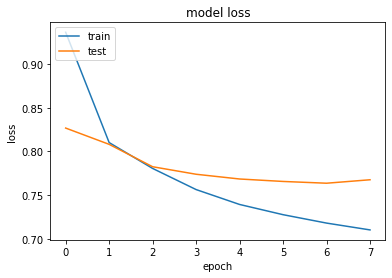

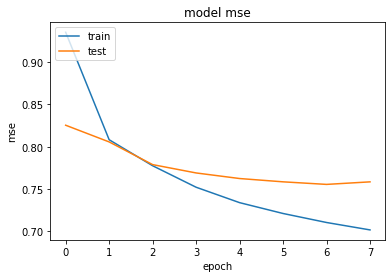

In [45]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()